Classification in GPflow
--

*Alexander G. de G. Matthews and James Hensman 2016*

This script replicates 

Hensman, Matthews, Ghahramani, AISTATS 2015, Scalable Variational Gaussian Process Classification, Figure 1 Row 1.

It serves to demonstrate sparse variational GP classification on a simple, easily visualized dataset.

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import csv
import numpy as np
import gpflow

In [2]:
Xtrain = np.loadtxt('data/banana_X_train', delimiter=',')
Ytrain = np.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)


In [3]:
def gridParams():
    mins = [-3.25,-2.85 ] 
    maxs = [ 3.65, 3.4 ]
    nGrid = 50
    xspaced = np.linspace( mins[0], maxs[0], nGrid )
    yspaced = np.linspace( mins[1], maxs[1], nGrid )
    xx, yy = np.meshgrid( xspaced, yspaced )
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot
     
def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Xplot)[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'o', color=col1, mew=0, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0], Xtrain[:,1][Ytrain[:,0]==0], 'o', color=col2, mew=0, alpha=0.5)
    if hasattr(m, 'Z'):
        Z = m.Z.read_value()
        ax.plot(Z[:,0], Z[:,1], 'ko', mew=0, ms=4)
        ax.set_title('m={}'.format(Z.shape[0]))
    else:
        ax.set_title('full')
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)
    


In [4]:
# Setup the experiment and plotting.
Ms = [4, 8, 16, 32, 64]


# Run sparse classification with increasing number of inducing points
models = []
for index, num_inducing in enumerate(Ms):
    # kmeans for selecting Z
    from scipy.cluster.vq import kmeans
    Z = kmeans(Xtrain, num_inducing)[0]

    m = gpflow.models.SVGP(
        Xtrain, Ytrain, kern=gpflow.kernels.RBF(2),
        likelihood=gpflow.likelihoods.Bernoulli(), Z=Z)
    # Initially fix the hyperparameters.
    m.Z.set_trainable(False)
    gpflow.train.ScipyOptimizer().minimize(m, maxiter=20)
    
    # Unfix the hyperparameters.
    m.Z.set_trainable(True)
    gpflow.train.ScipyOptimizer(options=dict(maxiter=200)).minimize(m)
    models.append(m)




INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 269.389036
  Number of iterations: 21
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 213.997929
  Number of iterations: 58
  Number of functions evaluations: 71
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 147.770045
  Number of iterations: 21
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.719015
  Number of iterations: 178
  Number of functions evaluations: 197
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 124.766878
  Number of ite

In [5]:
# Run variational approximation without sparsity..
# ..be aware that this is much slower for big datasets,
# but relatively quick here.
m = gpflow.models.VGP(Xtrain, Ytrain,
                   kern=gpflow.kernels.RBF(2),
                   likelihood=gpflow.likelihoods.Bernoulli())
gpflow.train.ScipyOptimizer().minimize(m, maxiter=2000)
models.append(m)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.660984
  Number of iterations: 241
  Number of functions evaluations: 254


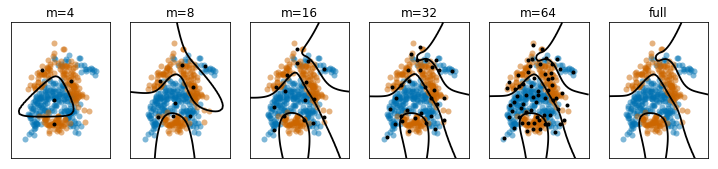

In [6]:
# make plots.
fig, axes = plt.subplots(1, len(models), figsize=(12.5, 2.5), sharex=True, sharey=True)
for i, m in enumerate(models):
    plot(m, axes[i])
    axes[i].set_yticks([])
    axes[i].set_xticks([])